## 데이터 스크래이핑

구글 코랩에서 `selenium`을 활용하려면 `chromium`과 `chromedriver`를 직접 설치해야 한다. 내가 쓴 코드는 아님. 

In [1]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.1K5ti5foVV/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.UyfZoXyzgm/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.1s2MgPaJ1c/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian bust

In [115]:
import base64
import time
import json
import requests
import pandas as pd

from io import BytesIO

from PIL import Image

from pprint import pprint

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

로깅을 허용하여 네트워크 패키지를 분석할 것이다.

In [14]:
capabilities = DesiredCapabilities.CHROME
capabilities['goog:loggingPrefs'] = {'performance': 'ALL'}

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument("--window-size=600,1000")

wd = webdriver.Chrome('chromedriver', options=chrome_options, desired_capabilities=capabilities)

In [15]:
actions = ActionChains(wd)

In [16]:
def show_page():
    bytes_decoded = base64.b64decode(wd.get_screenshot_as_base64())
    img = Image.open(BytesIO(bytes_decoded))
    img.show()

In [74]:
wd.get("https://app.catchtable.co.kr/ct/search/list")

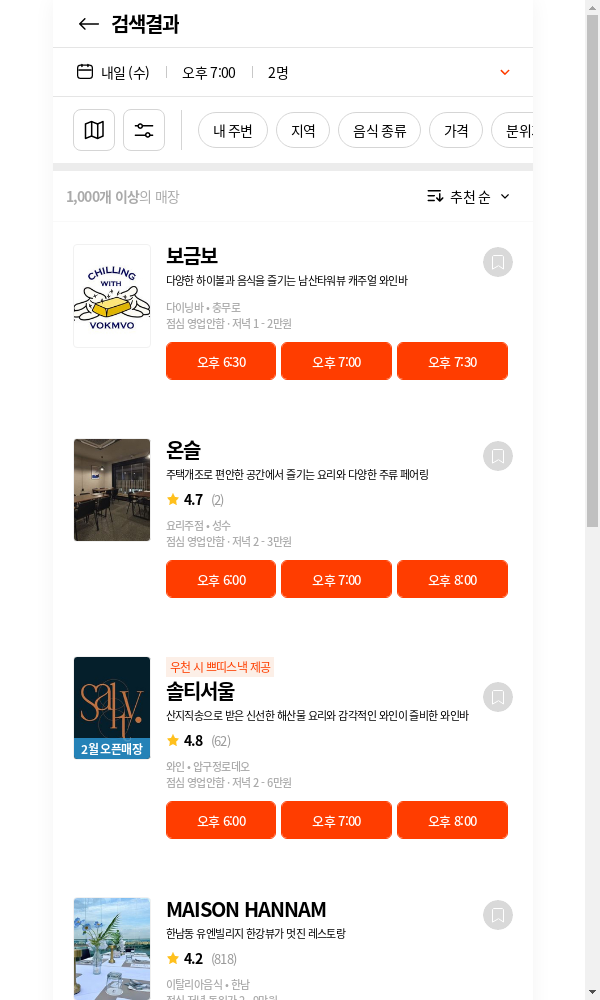

In [77]:
show_page()

In [78]:
wd.find_element(By.LINK_TEXT, '지역').click()

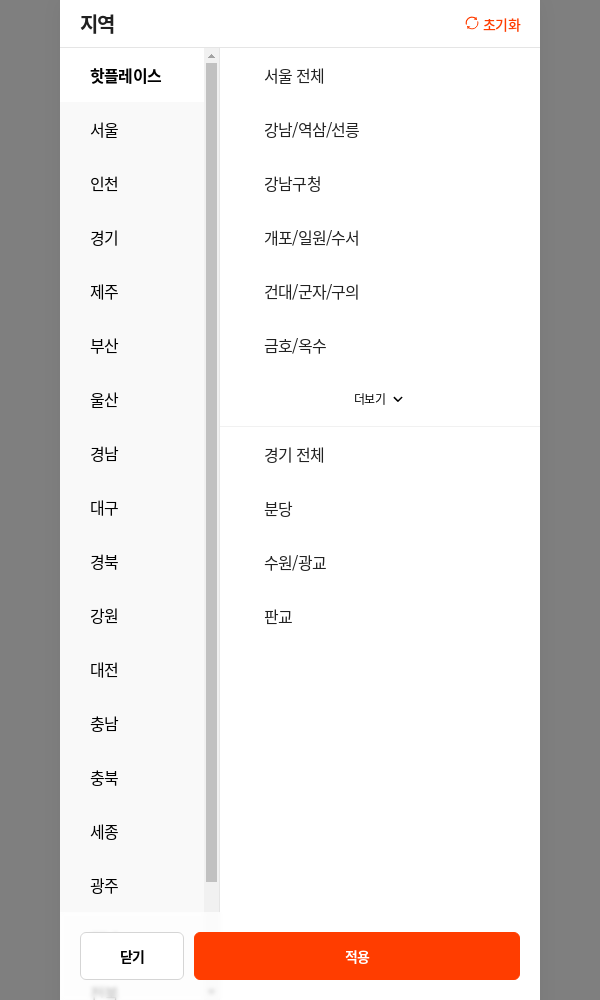

In [79]:
show_page()

In [80]:
wd.find_element(By.LINK_TEXT, '서울').click()

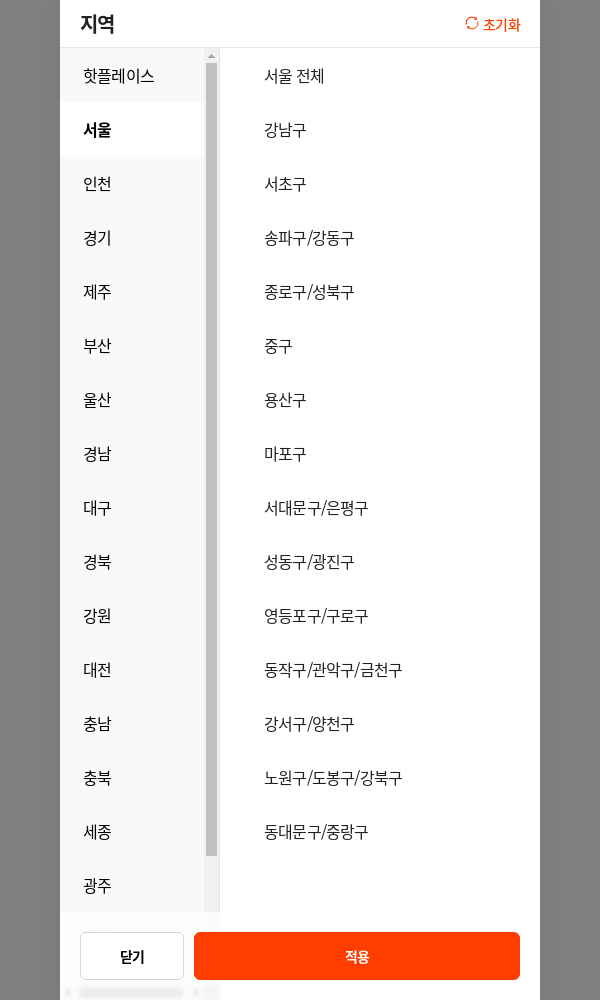

In [81]:
show_page()

In [82]:
region_categories = wd.find_element(By.CLASS_NAME, '__cat2')

for region in region_categories.find_elements(By.TAG_NAME, 'li'):
    if region.text == '노원구/도봉구/강북구':
        region.click()
        break

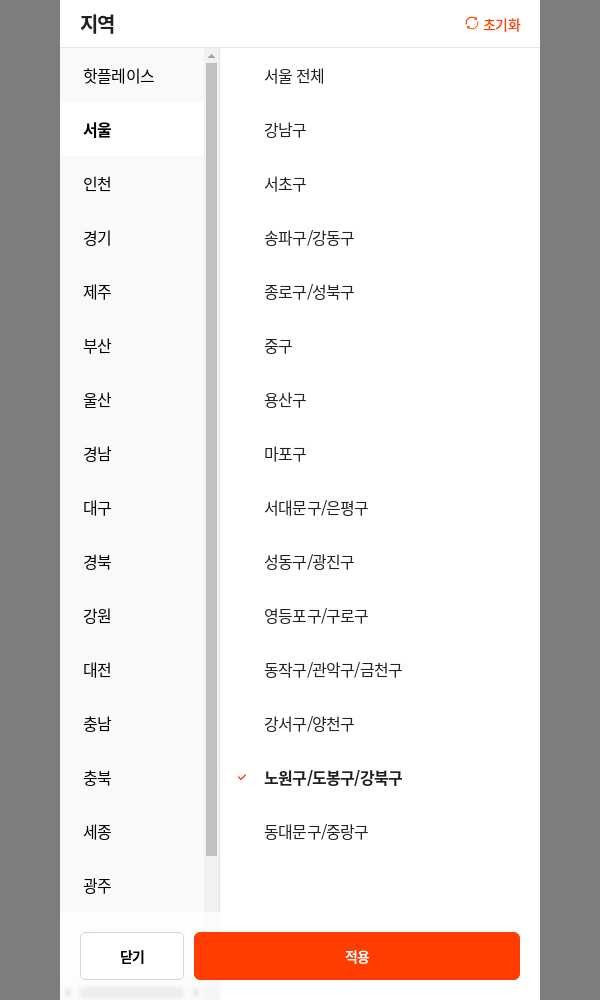

In [83]:
show_page()

In [84]:
wd.find_element(By.XPATH, '''//*[contains(text(), '적용')]''').click()

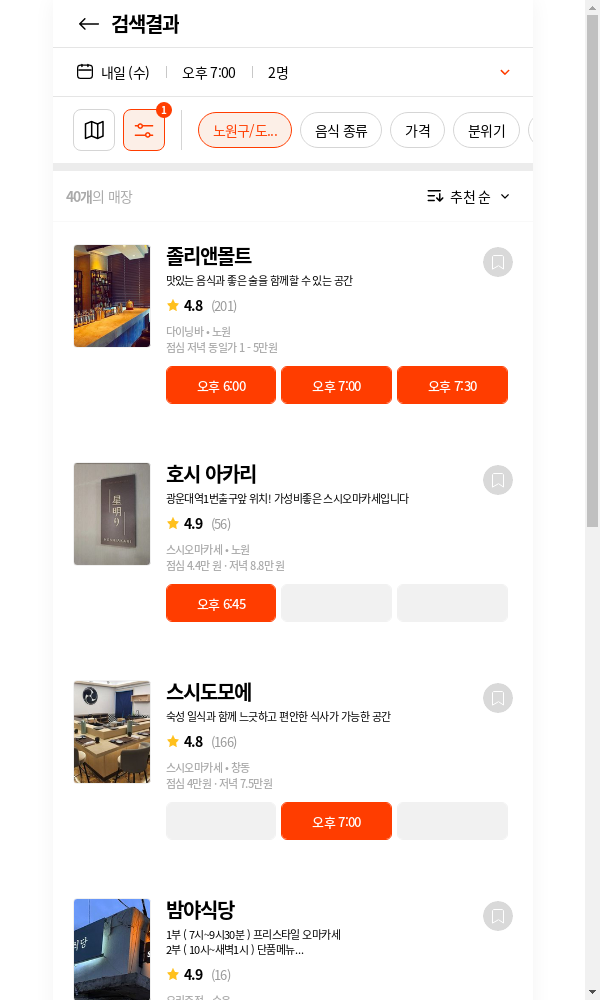

In [86]:
show_page()

캐치테이블 앱이 페이지에 렌더링 되는 부분만 request를 보내기 때문에 가장 밑까지 스크롤하여 전체 음식점 리스트를 불러온다.

In [87]:
SCROLL_PAUSE_SEC = 1

# 스크롤 높이 가져옴
last_height = wd.execute_script("return document.body.scrollHeight")

while True:
    # 끝까지 스크롤 다운
    wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # 1초 대기
    time.sleep(SCROLL_PAUSE_SEC)

    # 스크롤 다운 후 스크롤 높이 다시 가져옴
    new_height = wd.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

In [88]:
logs = wd.get_log('performance')
logs = [json.loads(log['message'])['message'] for log in logs]

In [93]:
shop_aliases = []
shop_refs = []

for log in logs:
    try:
        if log['params']['type'] == 'XHR' and log['method'] == 'Network.responseReceived' and log['params']['response']['url'] == 'https://app.catchtable.co.kr/api/v3/search/list':
            body = wd.execute_cdp_cmd('Network.getResponseBody', {'requestId': log["params"]["requestId"]})
            entries = json.loads(body['body'])['data']['entries']

            for entry in entries:
                if entry['shopDetail']['exSiGunGu'] in ['노원구', '도봉구', '강북구']:
                    shop_aliases.append(entry['shopDetail']['alias'])
                    shop_refs.append(entry['shopDetail']['shopRef'])

    except:
        pass

In [97]:
scores = {}

for alias, ref in zip(shop_aliases, shop_refs):
    ret = requests.get('https://app.catchtable.co.kr/api/v3/review/get-shop-review-info/' + ref).json()
    scores[alias] = ret['data']['score']

In [122]:
df = pd.DataFrame({
    'shop_alias': shop_aliases,
    'shop_ref': shop_refs
})

In [123]:
# scores' indexes are number of stars

df['scores'] = df['shop_alias'].map(scores)

In [124]:
df.head()

,shop_alias,shop_ref,scores
0,jollyandmalt,q1DfJGpRNaCnbP07pUI6dg,"[0, 1, 2, 11, 49, 138]"
1,hoshiakari,kvP46zb-0F0uEppwXGikZA,"[0, 0, 0, 1, 12, 43]"
2,sushido,38Gfm8zlnYoUzYbZdqoXGA,"[0, 2, 3, 3, 34, 124]"
3,ya.restaurant,xuVWJPY8VshBcCtOHbkdJQ,"[0, 0, 0, 0, 1, 15]"
4,forestwood,dueKUJUCJe_RjNmHjYPTlQ,"[0, 0, 0, 0, 0, 17]"


In [130]:
# dirichlet posterior for 5 star expectation

df['5_star_expectation'] = df['scores'].apply(lambda x: (x[5] + 1) / (sum(x[1:]) + 5))

In [132]:
df.sort_values('5_star_expectation', ascending=False)

,shop_alias,shop_ref,scores,5_star_expectation
31,sushichosim,-8at6Ly26Hcs_MHlvl9Abg,"[0, 3, 3, 19, 105, 754]",0.849269
4,forestwood,dueKUJUCJe_RjNmHjYPTlQ,"[0, 0, 0, 0, 0, 17]",0.818182
30,leeha5135,Za3Qn3CDZJv7Cy29f7e1Qw,"[0, 0, 2, 11, 10, 112]",0.807143
27,Y2F0Y2hfamJJQ1VPRkNTcFg5MW9BZUp4T3lwUT09,-kIRQmURs7r-z4v_CE2jDQ,"[0, 1, 3, 8, 48, 231]",0.783784
29,sushihakuya,xxDGYDrwUVwaaUM-R9uVBw,"[0, 3, 7, 27, 119, 525]",0.766764
3,ya.restaurant,xuVWJPY8VshBcCtOHbkdJQ,"[0, 0, 0, 0, 1, 15]",0.761905
28,dietro,IGhRefP37yhRvUUZRuhZIg,"[0, 0, 0, 8, 48, 185]",0.756098
2,sushido,38Gfm8zlnYoUzYbZdqoXGA,"[0, 2, 3, 3, 34, 124]",0.730994
1,hoshiakari,kvP46zb-0F0uEppwXGikZA,"[0, 0, 0, 1, 12, 43]",0.721311
0,jollyandmalt,q1DfJGpRNaCnbP07pUI6dg,"[0, 1, 2, 11, 49, 138]",0.674757


여전히 scraping은 좋지 않은 방법이라 생각한다. UI/UX가 바뀌면 알고리즘의 상당 부분을 수정해야 되는 경우도 있고, 혹, frontend에 공개되는 정보가 바뀌면 아예 접근을 다르게 해야될 수도 있기 때문이다. (이건 그냥 내 개인적인 의견이지만, 엘레강스가 떨어진다고 생각한다. 코드의 엘레강스가 없으면 코드를 읽었을때 뭔가 찝찝하고 불편하다.) Scalability를 고려하지 않고 기간이 짧은 프로젝트의 경우에만 적용하고자 한다. UI/UX가 프로젝트를 진행하는 동안 바뀔수도 있다!!